### Урок3. Связь бизнес-показателей и DS-метрик

In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

import warnings
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_csv('C:\\Users\\Mell\\Desktop\\materials3\\train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [55]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [56]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [57]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [58]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867397811595499+-0.008587216885603979


Посчитаем precision/recall/f_score

In [59]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386943, F-Score=0.730, Precision=0.647, Recall=0.837


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

In [60]:
def ROC_curve_plt (y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

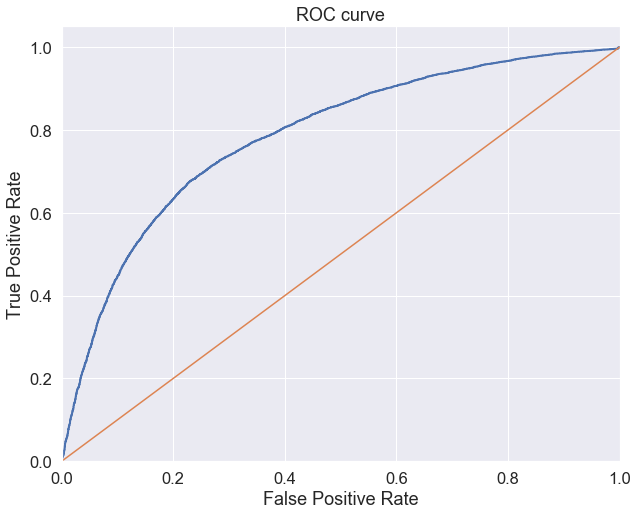

In [61]:
ROC_curve_plt(y_test, y_score)

In [67]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))
roc_auc_score_log = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])

roc auc score: 0.7840286921220101
log loss score: 0.5779642553522364


Посмотрим на матрицу ошибок

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4862 3958]
 [1412 7268]]


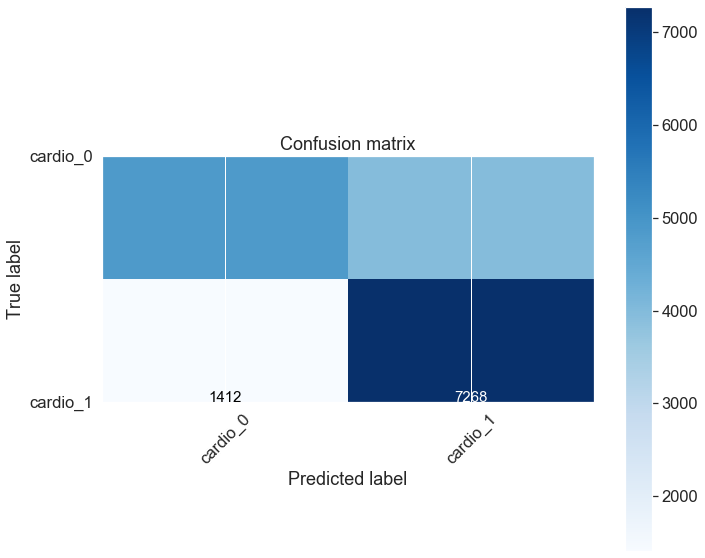

In [64]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## RandomForestClassifier ##

In [97]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,300,500]
max_depth = [3,6,10]
min_samples_split = [2,4,8,10,20]
min_samples_leaf = [2,4,8,10,20]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 19.0min finished


{'bootstrap': False,
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [99]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 42, max_depth = 10, 
                                          min_samples_leaf = 2,min_samples_split = 2, n_estimators = 100)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_RF, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_RF.fit(X_train, y_train)
y_score = classifier_RF.predict_proba(X_test)[:, 1]

CV score is 0.8016891604751416+-0.007057893443295711


In [100]:
b=1
precision_RF, recall_RF, thresholds_RF = precision_recall_curve(y_test.values, y_score)
fscore_RF = (1+b**2)*(precision_RF * recall_RF) / (b**2*precision_RF + recall_RF)
# locate the index of the largest f score
ix = np.argmax(fscore_RF)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_RF[ix], 
                                                                        fscore_RF[ix],
                                                                        precision_RF[ix],
                                                                        recall_RF[ix]))

Best Threshold=0.399847, F-Score=0.740, Precision=0.700, Recall=0.785


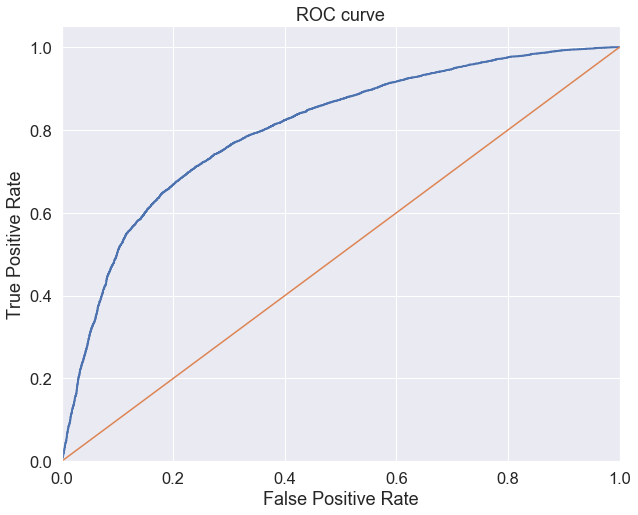

In [101]:
ROC_curve_plt(y_test, y_score)

In [102]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_RF.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_RF.predict_proba(X_test)[:,1])))
roc_auc_score_RF = roc_auc_score(y_true=y_test, y_score=classifier_RF.predict_proba(X_test)[:,1])

roc auc score: 0.8014517957720723
log loss score: 0.5422856552726756


Confusion matrix, without normalization
[[6234 2586]
 [2129 6551]]


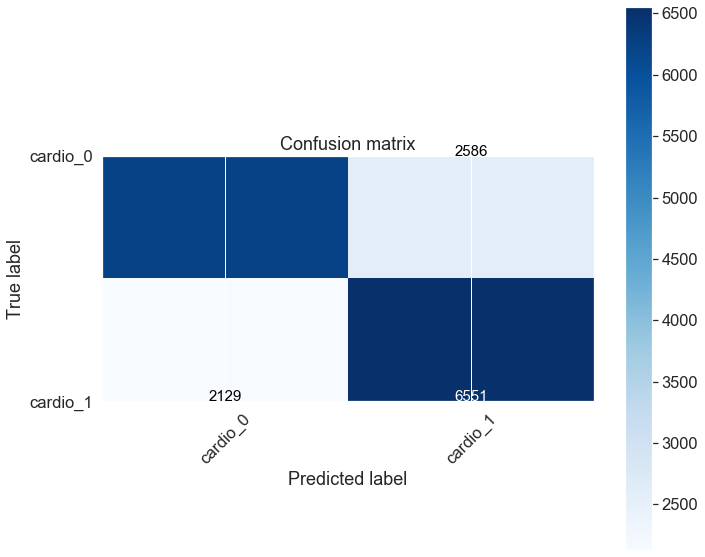

In [103]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## GradientBoostingClassifier ##

In [105]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_GB = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_GB, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_GB.fit(X_train, y_train)
y_score = classifier_GB.predict_proba(X_test)[:, 1]

CV score is 0.8024721950300286+-0.007119077207003447


In [106]:
b=1
precision_GB, recall_GB, thresholds_GB = precision_recall_curve(y_test.values, y_score)
fscore_GB = (1+b**2)*(precision_GB * recall_GB) / (b**2*precision_GB + recall_GB)
# locate the index of the largest f score
ix = np.argmax(fscore_GB)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_RF[ix], 
                                                                        fscore_RF[ix],
                                                                        precision_RF[ix],
                                                                        recall_RF[ix]))

Best Threshold=0.297641, F-Score=0.732, Precision=0.625, Recall=0.883


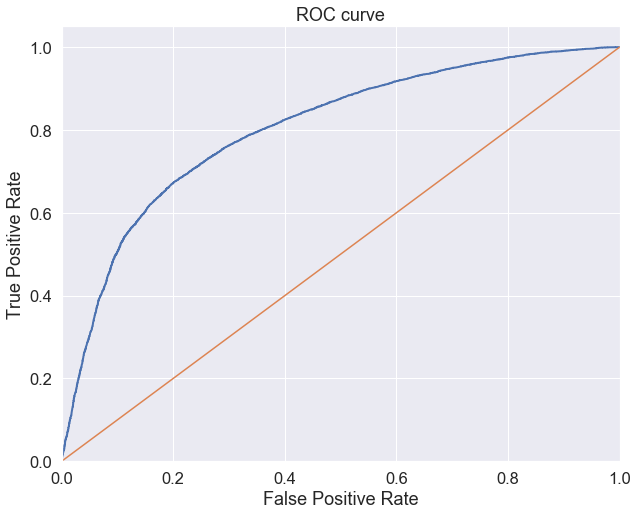

In [107]:
ROC_curve_plt(y_test, y_score)

In [121]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_GB.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_GB.predict_proba(X_test)[:,1])))
roc_auc_score_GB = roc_auc_score(y_true=y_test, y_score=classifier_GB.predict_proba(X_test)[:,1])

roc auc score: 0.8026153641179974
log loss score: 0.5397460438742135


Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


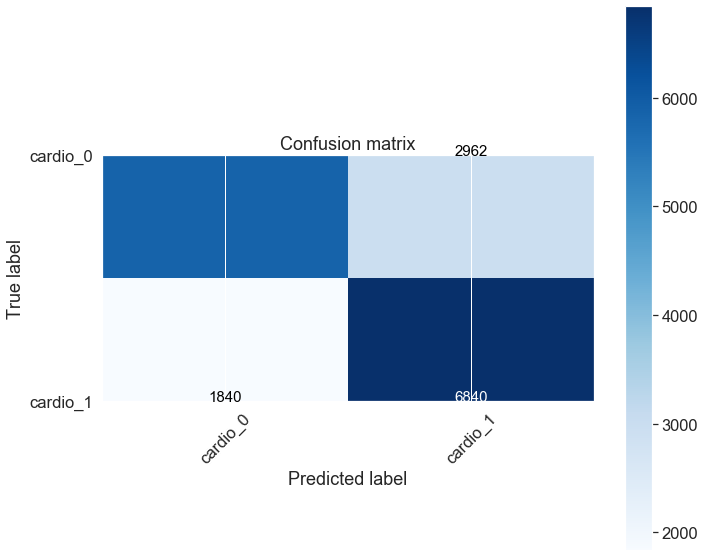

In [122]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds_GB[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [123]:
log_res = [precision[ix], recall[ix],fscore[ix], roc_auc_score_log]
RF_res = [precision_RF[ix], recall_RF[ix],fscore_RF[ix], roc_auc_score_RF]
GB_res = [precision_GB[ix], recall_GB[ix],fscore_GB[ix], roc_auc_score_GB]

In [124]:
results = pd.DataFrame({'LogReg': log_res,
                        'RandomForest': RF_res,
                        'GradientBoosting': GB_res}).T
results.columns=['precision', 'recall','f1_score','Roc_auc_score']

In [125]:
results

,precision,recall,f1_score,Roc_auc_score
LogReg,0.615910,0.883065,0.725680,0.784029
RandomForest,0.624623,0.882604,0.731535,0.801452
GradientBoosting,0.697848,0.788134,0.740248,0.802615


Random Forest и Логистическая регрессия показали лучшие значения recall, при этом занизив precision. Градиентный бустинг показал меньшую разницу между precision и recall, и в итоге показал лучшие результаты f1_score и Roc_auc_score.